In [1]:
import matplotlib.pyplot as plt
import numpy as np  

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, GPT2LMHeadModel

/lustre/hpc/pheno/inar/mambaforge/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

### Get unembedding matrix and its pseudo-inverse

In [4]:
#Where is it documented?
# Check if works for all models 
unembed = model.get_output_embeddings().weight.detach()

In [70]:
embed = model.get_input_embeddings().weight.detach()

In [5]:
vocab_size, hidden_dim = unembed.shape
vocab_size, hidden_dim

(50257, 768)

In [6]:
# cross check
inputs = tokenizer("This is a test", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

test_logits = outputs.logits.detach()
explicit_logits = outputs.hidden_states[-1] @ unembed.T

assert torch.allclose(test_logits, explicit_logits)

In [7]:
Wai = unembed.numpy()
pinvWai = np.linalg.pinv(Wai) 

In [8]:
Wai.shape, pinvWai.shape    

((50257, 768), (768, 50257))

In [9]:
(pinvWai @ Wai).shape

(768, 768)

In [25]:
torch.allclose(torch.eye(hidden_dim), torch.tensor(pinvWai @ Wai), atol = 1e-5)

True

In [28]:
pinvWai[:,10].shape

(768,)

In [65]:
pinvWai.shape

(768, 50257)

### Compare with just embed unembed

In [74]:
embed[0].shape

torch.Size([768])

In [114]:
(unembed @ embed[0])

tensor([9.4149, 4.2346, 3.6138,  ..., 2.4549, 3.4507, 3.7520])

In [115]:
values, indices = torch.topk(unembed @ model.transformer.ln_f(embed[tokenizer.encode(" Jedi")[0]]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([177.4284, 146.1846, 145.1146, 138.4406, 131.7341, 131.6381, 130.6968,
        129.3357, 128.9295, 124.8398, 124.2905, 123.3975, 123.3646, 122.9185,
        122.8100, 122.7172, 122.6031, 121.9147, 121.6071, 121.4551],
       grad_fn=<TopkBackward0>)
tensor([16147, 26455, 45282, 46217, 46662, 29715, 41212, 46748, 31152, 46546,
        41715, 23509, 17787, 11273, 48653,  8346, 48131, 11896, 44280, 27403])


' Jedi Sith lightsaber Kenobi Obi Skywalker Leia droid Darth Droid Mandal Galactic cryst enthusi Jinn condem blaster mathemat galactic Vader'

In [112]:
values, indices = torch.topk(unembed @ embed[tokenizer.encode(" Jedi")[0]],k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([13.8825, 10.6094, 10.5480,  9.9761,  9.3562,  9.3173,  9.2371,  9.0130,
         8.8415,  8.3884,  8.3651,  8.1557,  8.1267,  8.1095,  7.9533,  7.9510,
         7.9154,  7.8479,  7.8156,  7.6337])
tensor([16147, 26455, 45282, 46217, 41212, 29715, 46662, 46748, 31152, 46546,
        41715, 48653, 27403, 23509, 48131, 45684, 43583, 44280, 42424, 39613])


' Jedi Sith lightsaber Kenobi Leia Skywalker Obi droid Darth Droid Mandal Jinn Vader Galactic blaster Klingon Starfleet galacticDragonMagazine Awakens'

In [118]:
values, indices = torch.topk(1000*torch.tensor(Wai @ pinvWai[:,tokenizer.encode(" Jedi")[0]]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([11.0593,  6.2251,  5.5339,  4.3988,  4.3304,  4.2886,  4.2752,  4.0908,
         3.9618,  3.6608,  3.6329,  3.2905,  2.9408,  2.9123,  2.9098,  2.8769,
         2.8713,  2.8690,  2.8478,  2.7731])
tensor([16147, 26455, 45282, 29715, 46662, 46217, 41212, 31152, 23509, 46748,
        41715, 27403, 44280, 30698, 46546, 48131, 48744,  5221, 43583, 45684])


' Jedi Sith lightsaber Skywalker Obi Kenobi Leia Darth Galactic droid Mandal Vader galactic Clone Droid blaster starship Force Starfleet Klingon'

In [80]:
embed[2000][:10]

tensor([ 0.1676, -0.0584,  0.1382, -0.0092,  0.0161,  0.0339, -0.3739,  0.0490,
        -0.1165,  0.0488])

In [82]:
pinvWai[:,2000][:10] * 0.1676/3.2731093e-04

array([ 0.1676    , -0.02892693,  0.18787754, -0.01588115,  0.0493995 ,
        0.0711918 , -0.2297442 ,  0.14890768, -0.10954105,  0.00886676],
      dtype=float32)

In [116]:
torch.nn.CosineSimilarity(dim=0)(embed[2000], torch.tensor(pinvWai[:,2000]))

tensor(0.1774)

In [117]:
torch.nn.CosineSimilarity(dim=0)(embed[2000], embed[2000])

tensor(1.)

### Using ingeneered features

In [210]:
tokenizer.encode(" mind")

[2000]

In [212]:
values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,2000]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0144, 0.0097, 0.0087, 0.0078, 0.0062, 0.0042, 0.0042, 0.0040, 0.0040,
        0.0038, 0.0036, 0.0033, 0.0032, 0.0032, 0.0031, 0.0031, 0.0031, 0.0031,
        0.0030, 0.0030])
tensor([ 2000,  9017, 10155, 10175, 28478, 13843,  3632, 35661, 39006, 20527,
         5848, 18346,  4151,  6094, 27825,  2612, 21332, 14543, 44687, 17627])


' mind mindsmind MindMind imagination brain minded psyche mindset soul conscience eye towbrain heart mentalitymindedBrain senses'

In [82]:
tokenizer.encode(" anime")

[11984]

In [121]:
values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,11984]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0092, 0.0059, 0.0055, 0.0031, 0.0031, 0.0029, 0.0028, 0.0028, 0.0027,
        0.0027, 0.0026, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024,
        0.0024, 0.0024])
tensor([11984, 15911, 27812, 27024, 25324,  3807, 12770, 16251,  4960, 11034,
        23535, 30070, 15108,  9048, 15875,  6918, 10873,  2646, 38668, 32467])


' anime manga Anime MangaJapanese movie comics cartoon Japanese animation Animation cartoons animated comic Movie movies dub filmepisode Gundam'

In [241]:

values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,tokenizer.encode(" William")[0]]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0073, 0.0056, 0.0031, 0.0029, 0.0028, 0.0027, 0.0026, 0.0026, 0.0025,
        0.0025, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023,
        0.0023, 0.0023])
tensor([ 3977, 17121, 10443,  5199, 17100,  4502,  6219,  7516, 14576,  1757,
        42602, 29470, 12803,  8616, 15819, 14430, 20320, 37016, 19156,  5658])


' WilliamWilliam Edward Robert Samuel George Richard Charles Philip John Clarence Phillip Christopher Henry Walter Ronald Nicholas EdwinRobert Thomas'

In [26]:
torch.nn.CosineSimilarity(dim=0)(torch.tensor(pinvWai[:,tokenizer.encode(" Richard")[0]]),torch.tensor(pinvWai[:,tokenizer.encode(" William")[0]]))

tensor(0.9818)

In [27]:
torch.nn.CosineSimilarity(dim=0)(torch.tensor(pinvWai[:,tokenizer.encode(" Richard")[0]]),torch.tensor(pinvWai[:,tokenizer.encode(" cat")[0]]))

tensor(-0.9735)

In [32]:
torch.nn.CosineSimilarity(dim=0)(torch.tensor(pinvWai[:,tokenizer.encode(" Richard")[0]]),torch.tensor(pinvWai[:,tokenizer.encode(" Anna")[0]]))

tensor(-0.9386)

In [37]:
metric = Wai.T @ Wai

In [39]:
pinvWai[:,tokenizer.encode(" Anna")[0]]@metric@pinvWai[:,tokenizer.encode(" Richard")[0]]

0.0003390096

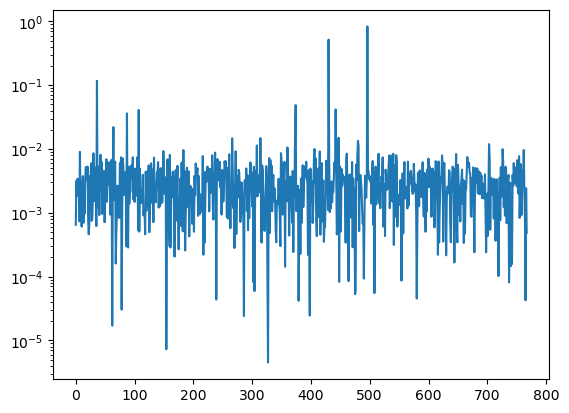

In [54]:
t_ex = pinvWai[:,tokenizer.encode(" Jedi")[0]]
t_ex = t_ex / np.linalg.norm(t_ex)
plt.semilogy(np.abs(t_ex))

In [57]:
force_token = tokenizer.encode(" Jedi")[0]
print(force_token)

values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,force_token]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

16147
tensor([0.0111, 0.0062, 0.0055, 0.0044, 0.0043, 0.0043, 0.0043, 0.0041, 0.0040,
        0.0037, 0.0036, 0.0033, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029,
        0.0028, 0.0028])
tensor([16147, 26455, 45282, 29715, 46662, 46217, 41212, 31152, 23509, 46748,
        41715, 27403, 44280, 30698, 46546, 48131, 48744,  5221, 43583, 45684])


' Jedi Sith lightsaber Skywalker Obi Kenobi Leia Darth Galactic droid Mandal Vader galactic Clone Droid blaster starship Force Starfleet Klingon'

tensor([0.2562, 0.1440, 0.1280, 0.1008, 0.1002, 0.0993, 0.0992, 0.0942, 0.0931,
        0.0838, 0.0833, 0.0768, 0.0673, 0.0671, 0.0665, 0.0665, 0.0661, 0.0657,
        0.0657, 0.0652])
tensor([16147, 26455, 45282, 29715, 41212, 46662, 46217, 31152, 23509, 46748,
        41715, 27403, 44280, 48131, 48744,  5221, 30698, 46546, 43583, 45684])


' Jedi Sith lightsaber Skywalker Leia Obi Kenobi Darth Galactic droid Mandal Vader galactic blaster starship Force Clone Droid Starfleet Klingon'

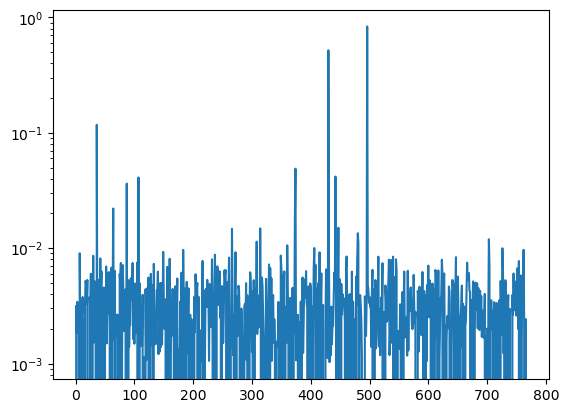

In [68]:
t_ex = pinvWai[:,tokenizer.encode(" Jedi")[0]]
t_ex = t_ex / np.linalg.norm(t_ex)

t_ex[np.abs(t_ex) < 1e-3] = 0.0

plt.semilogy(np.abs(t_ex))

values, indices = torch.topk(torch.tensor(Wai @ t_ex),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

In [252]:
values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,tokenizer.encode(" Kubrick")[0]]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0135, 0.0046, 0.0036, 0.0034, 0.0031, 0.0029, 0.0029, 0.0028, 0.0028,
        0.0027, 0.0027, 0.0026, 0.0026, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0025])
tensor([46354, 41151, 49817, 43693, 14167, 37655, 41364, 40365, 39616, 26240,
        39162, 33430, 24921, 42311, 27788, 35579, 13741, 16683, 46858, 27286])


' Kubrick Spielberg Hitchcock Tarant Stanley Lovecraftmovie Nicholson Ridleyfilm Kissinger Freud Kubarnaev Nolan Mechdragon Filmkees Canaverperture'

In [225]:
force_token = tokenizer.encode(" Kenobi")[0]
force_token

46217

In [226]:
values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,force_token]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0167, 0.0068, 0.0051, 0.0046, 0.0045, 0.0044, 0.0043, 0.0041, 0.0040,
        0.0034, 0.0034, 0.0032, 0.0032, 0.0032, 0.0031, 0.0031, 0.0029, 0.0029,
        0.0029, 0.0028])
tensor([46217, 29715, 46662, 48653, 27403, 46748, 16147, 41212, 45282, 20284,
        48131, 26455, 37945, 49226, 27442, 39004, 33353, 41715, 46546, 45681])


' Kenobi Skywalker Obi Jinn Vader droid Jedi Leia lightsaber Solo blaster Sith Spock Weasley Dumbledore Lannvae Mandal DroidWan'

In [237]:
force_token = tokenizer.encode(" Jedi")[0]
print(force_token)

values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,force_token]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

16147
tensor([0.0111, 0.0062, 0.0055, 0.0044, 0.0043, 0.0043, 0.0043, 0.0041, 0.0040,
        0.0037, 0.0036, 0.0033, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029,
        0.0028, 0.0028])
tensor([16147, 26455, 45282, 29715, 46662, 46217, 41212, 31152, 23509, 46748,
        41715, 27403, 44280, 30698, 46546, 48131, 48744,  5221, 43583, 45684])


' Jedi Sith lightsaber Skywalker Obi Kenobi Leia Darth Galactic droid Mandal Vader galactic Clone Droid blaster starship Force Starfleet Klingon'

In [239]:
token_id = tokenizer.encode("facebook")[0]
print(token_id)

values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,token_id]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

19024
tensor([0.0194, 0.0076, 0.0076, 0.0069, 0.0059, 0.0056, 0.0045, 0.0045, 0.0040,
        0.0038, 0.0038, 0.0037, 0.0036, 0.0036, 0.0036, 0.0035, 0.0033, 0.0032,
        0.0032, 0.0032])
tensor([19024,  6956, 12025, 23960, 11604,  3203, 49836, 14254, 33103, 31844,
        17044, 34877, 47745, 13297, 13186, 46587, 48842, 26001, 10767, 10748])


'facebooktwitterFacebook facebookyoutube FacebookFACETwitteramazontwitch twitteretsymeetgoogle FB FACENECTFB Instagramreddit'

In [83]:
tokenizer.encode(" catgirl")

[3797, 15219]

In [217]:
values, indices = torch.topk(torch.tensor(Wai @ (pinvWai[:,3797] + pinvWai[:,15219])),k = 20)
print(values)
print(indices)
[tokenizer.decode(i) for i in indices]

tensor([0.0174, 0.0109, 0.0105, 0.0086, 0.0079, 0.0075, 0.0075, 0.0070, 0.0069,
        0.0068, 0.0067, 0.0061, 0.0060, 0.0054, 0.0050, 0.0050, 0.0050, 0.0049,
        0.0048, 0.0048])
tensor([15219,  3797, 36960, 24151,  2576,  7081,  9246, 21979,  5181,  8580,
         7430, 11875, 13202,  4813, 24619, 28997,  2933, 42143, 32408,  2415])


['girl',
 ' cat',
 'girls',
 'Girl',
 ' girl',
 'boy',
 'cat',
 'Cat',
 ' Cat',
 'woman',
 ' Girl',
 ' cats',
 'boys',
 ' girls',
 'cats',
 ' Cats',
 ' boy',
 ' kitten',
 ' catcher',
 ' woman']

In [118]:
tokenizer.encode(" look")

[804]

In [119]:
values, indices = torch.topk(torch.tensor(Wai @ (pinvWai[:,804])),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.0108, 0.0071, 0.0070, 0.0069, 0.0063, 0.0061, 0.0059, 0.0050, 0.0047,
        0.0041, 0.0038, 0.0038, 0.0037, 0.0037, 0.0034, 0.0034, 0.0033, 0.0032,
        0.0030, 0.0030])
tensor([  804,  5460,  6803,  3073, 48045,  3114,  8567,  2045, 16086, 29403,
         1254, 11534, 15784,  6004, 22464, 24170, 27185,  6938, 41102, 15616])


' looklook Look looks LOOK lookedLook looking glance Looks feellookingLooking listen resemble stare peek tasteLooks Looking'

In [138]:
torch.tensor(Wai) @ model.transformer.ln_f(torch.tensor(pinvWai[:,2000]))

tensor([-0.7667, -0.7921, -2.7962,  ..., -5.3310, -5.1062, -0.9445],
       grad_fn=<MvBackward0>)

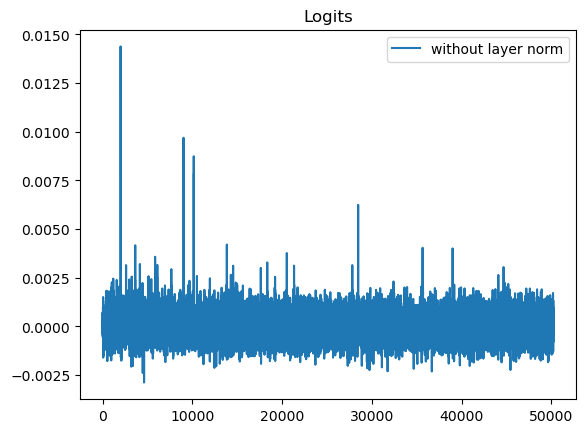

In [152]:
# plt.plot((torch.tensor(Wai) @ model.transformer.ln_f(torch.tensor(pinvWai[:,2000]))).detach().numpy(), label = 'with layer norm')
plt.plot((Wai @ pinvWai[:,2000]), label = 'without layer norm')
plt.title('Logits')
plt.legend()
plt.show()

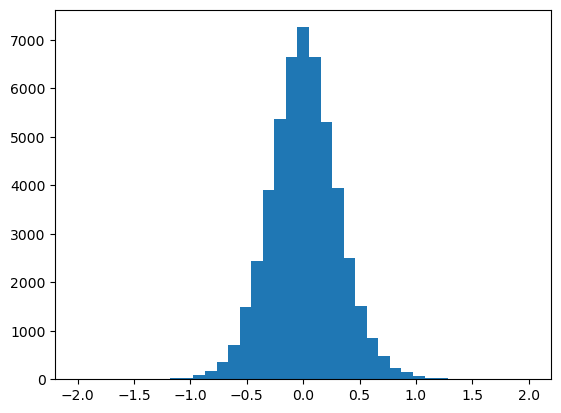

In [166]:
logits_example = 500*Wai @ pinvWai[:,1000]
plt.hist(logits_example, bins = np.linspace(-2,2,40));
# plt.yscale('log')

Text(0.5, 1.0, 'Logits')

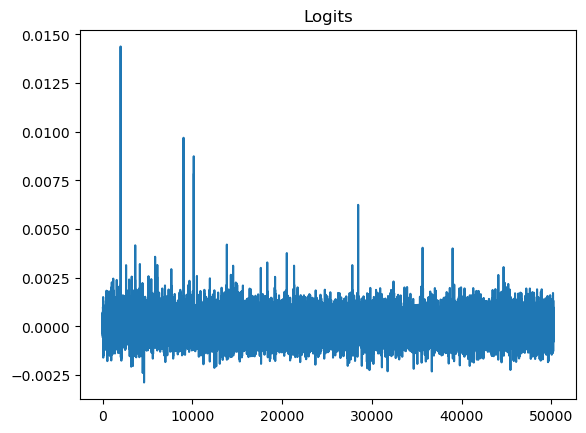

In [155]:
plt.plot((Wai @ pinvWai[:,2000]))
plt.title('Logits')

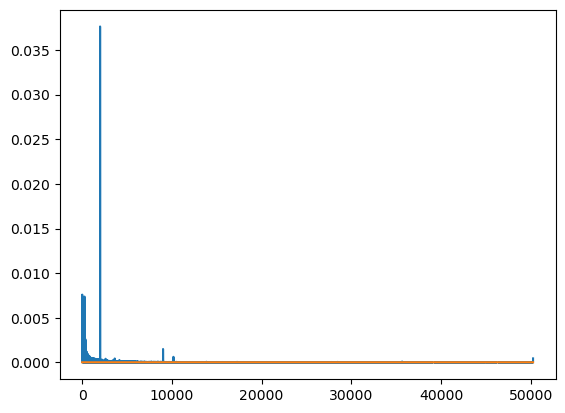

In [147]:
probs_nn = F.softmax(torch.tensor(Wai @ pinvWai[:,2000]), dim = 0)
probs = F.softmax((torch.tensor(Wai) @ model.transformer.ln_f(torch.tensor(pinvWai[:,2000]))),dim=0).detach().numpy()
plt.plot(probs)
plt.plot(probs_nn.detach().numpy())

In [206]:
vec1 = torch.tensor(pinvWai[:,1000])
vec2 = torch.tensor(pinvWai[:,2000])

vec = (vec1 + vec2)

vec1_ln = model.transformer.ln_f(vec1).detach()
vec2_ln = model.transformer.ln_f(vec2).detach()

vec_ln = model.transformer.ln_f(vec).detach()


In [209]:
torch.nn.CosineSimilarity(dim=0)(vec1, vec1_ln)

tensor(0.9837)

In [204]:
torch.nn.CosineSimilarity(dim=0)(vec1, vec2)

tensor(0.2600)

In [205]:
torch.nn.CosineSimilarity(dim=0)(vec1_ln, vec2_ln)

tensor(0.3618)

In [207]:
torch.nn.CosineSimilarity(dim=0)(vec, vec2)

tensor(0.6611)

In [208]:
torch.nn.CosineSimilarity(dim=0)(vec_ln, vec2_ln)

tensor(0.7026)

### Iso-Logit vector

This vector is mapped into $\ell_i = 1$. If added to any logit, it doesn't change the probability distribution

$$ p_i = \exp(\ell_i - F), \; F = - \log(Z) $$

Any constant shift $\ell_i \to \ell_i +C$ is abosrbed in F and doesn't change the probability distribution.



In [42]:
iso_vec = pinvWai @ np.ones(50257)

In [52]:
iso_tensor = torch.tensor(iso_vec, dtype=torch.float32)

In [97]:
iso_logits = torch.tensor(eq_vec, dtype=torch.float) @ unembed.T
iso_p = F.softmax(eq_logits, dim=-1)

iso_p.sum(), iso_p.max()*vocab_size, iso_p.min()*vocab_size

(tensor(1.0000), tensor(1.0239), tensor(0.9913))

In [118]:
(vocab_size*iso_p.numpy()).mean(), (vocab_size*iso_p.numpy()).std()

(0.9999995, 0.0012492756)

In [101]:
topk_iso_comp = torch.topk(iso_tensor.abs(),3)
topk_iso_comp

torch.return_types.topk(
values=tensor([2.2210, 0.9253, 0.8440]),
indices=tensor([496,  36, 430]))

In [102]:
iso_candidates = []
for i, v in zip(topk_iso_comp.indices, topk_iso_comp.values):
    if v > 0.5:
        iso_candidate = torch.zeros(hidden_dim)
        iso_candidate[i] = 1.0
        iso_candidates.append(iso_candidate)

In [114]:
for candidate in iso_candidates:
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    print(candidate_p.max()*vocab_size, candidate_p.std()*vocab_size)

tensor(1.0063) tensor(0.0008)
tensor(1.0252) tensor(0.0018)
tensor(1.0249) tensor(0.0013)


In [104]:
test_logits.shape

torch.Size([1, 4, 50257])

In [105]:
for logits in test_logits[0]:
    ptt = F.softmax(logits, dim=-1)
    print(ptt.max()*vocab_size)

tensor(2305.8027)
tensor(7934.9365)
tensor(2678.9431)
tensor(12669.1074)


In [112]:
max_ps = []
ps_std = []
for i in range(hidden_dim):
    candidate = torch.zeros(hidden_dim)
    candidate[i] = 1.0
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    max_ps.append(candidate_p.max())
    ps_std.append(candidate_p.std())

    

In [115]:
max_ps = np.array(max_ps)*vocab_size
ps_std = np.array(ps_std)*vocab_size

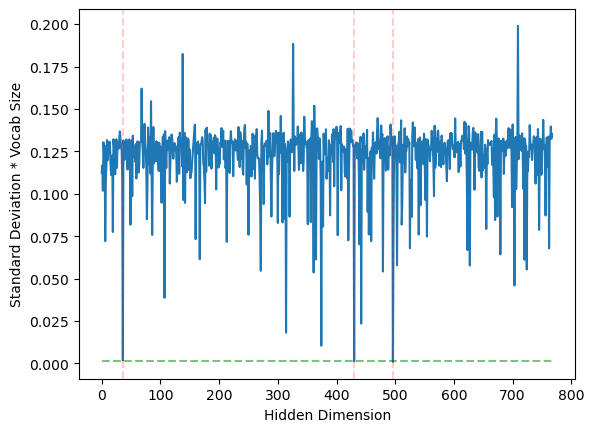

In [125]:
plt.plot(ps_std)
# add hline at iso_p.std()*vocab_size
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.2, label = 'iso candidates')
plt.hlines(iso_p.std()*vocab_size, 0, hidden_dim, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Hidden Dimension')
plt.ylabel('Standard Deviation * Vocab Size')

plt.show()

Text(0, 0.5, 'max probability*vocab_size')

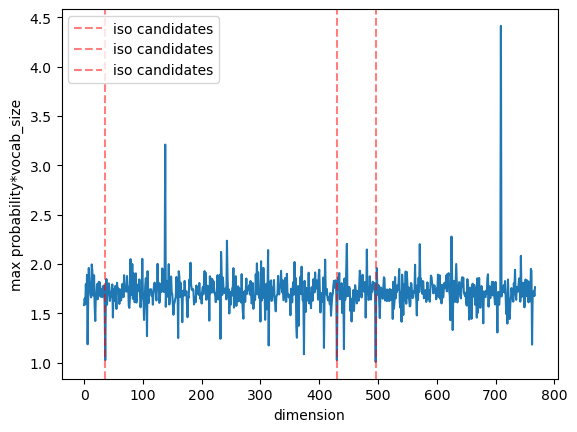

In [111]:
plt.plot(max_ps)
# add vertical lines at topk_iso_comp.indices
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.5, label = 'iso candidates')
plt.legend()
plt.xlabel('dimension')
plt.ylabel('max probability*vocab_size')